<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/financial_analyst_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install yfinance tavily-python langchain langchain-community langgraph langchain-groq langchain-tavily

##Step1 importing the Required Library🤓🤓

In [2]:
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
import yfinance as yf
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
import requests
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [3]:
from google.colab import userdata
tavily_api_key=userdata.get('Tavily_api_key')
api_key=userdata.get('groq_api_key')

In [4]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=api_key)

##Step2: Now Time for setting up tools🪚🪚🔨⚒️⚒️

In [14]:
@tool
def lookup_ticker(company_name: str):
    """
    Search for the correct stock ticker symbol given a company name.
    Use this FIRST if the user provides a name like "Apple", "Tesla", or "Diyo.ai".
    """
    url = "https://query2.finance.yahoo.com/v1/finance/search"
    headers = {'User-Agent': 'Mozilla/5.0'}
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    try:
        res = requests.get(url, params=params, headers=headers)
        data = res.json()
        if "quotes" in data and len(data["quotes"]) > 0:
            symbol = data["quotes"][0]["symbol"]
            return f"The ticker for {company_name} is {symbol}."
        return f"No ticker found for {company_name}."
    except Exception as e:
        return f"Error looking up ticker: {e}"


@tool
def get_stock_data(ticker: str, period: str = "1d"):
    """
    Get stock price data.

    Args:
        ticker: The stock symbol (e.g., AAPL).
        period: The timeframe to retrieve.
                Valid options: "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "max".
                Default is "1d" (current price).
    """
    ticker = ticker.replace("$", "").strip().upper()

    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)

        if hist.empty:
            return f"No data found for {ticker}."
        if period == "1d":
            price = hist['Close'].iloc[-1]
            return f"Current price of {ticker}: ${price:.2f}"
        return f"Stock history for {ticker} ({period}):\n{hist[['Close', 'Volume']].to_string()}"

    except Exception as e:
        return f"Error fetching data: {e}"

In [6]:
tavily_search=TavilySearch(max_results=5,search_depth="advanced",tavily_api_key=tavily_api_key)

In [7]:
tools=[lookup_ticker,get_stock_data,tavily_search]

In [8]:
llm_with_tools=llm.bind_tools(tools=tools)

In [9]:
def agent(state:MessagesState):
  message=state["messages"]
  system_prompt= SystemMessage(content=(
        "You are a Senior Financial Analyst. Your goal is to provide accurate stock data and news. "
        "Follow this process: "
        "1. If given a name ('Apple'), use 'lookup_ticker' to find the symbol ('AAPL'). "
        "2. If the user asks for history ('last 6 months'), pass '6mo' to the 'period' argument. "
        "3. Use 'tavily_search_results_json' for explaining WHY the price moved."
    ))
  llm_message=[system_prompt]+message
  response_llm=llm_with_tools.invoke(llm_message)
  return {"messages":[response_llm]}



In [10]:
workflow=StateGraph(MessagesState)
workflow.add_node("agent",agent)
workflow.add_node("tools",ToolNode(tools))
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent",tools_condition)
workflow.add_edge("tools","agent")
app=workflow.compile()

In [11]:
from IPython.display import Image,display

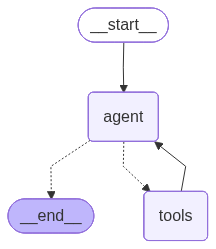

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
while True:
    query=input("Enter your query or enter exit:")
    if query.lower()=="exit":
        break
    else:
        events=app.stream({"messages":[query]},stream_mode="values")
        for event in events:
            event["messages"][-1].pretty_print()


Enter your query or enter exit:helo
================================ Human Message =================================

helo
================================== Ai Message ==================================

Hello! How can I help you today?
Enter your query or enter exit:should i invest in Tesla?
================================ Human Message =================================

should i invest in Tesla?
================================== Ai Message ==================================
Tool Calls:
  lookup_ticker (fc_10c8062c-2ee6-442a-9485-f98c93aa7664)
 Call ID: fc_10c8062c-2ee6-442a-9485-f98c93aa7664
  Args:
    company_name: Tesla
================================= Tool Message =================================
Name: lookup_ticker

The ticker for Tesla is TSLA.
================================== Ai Message ==================================
Tool Calls:
  get_stock_data (fc_70d2e502-fb1d-4b2f-bae0-7188d1385c64)
 Call ID: fc_70d2e502-fb1d-4b2f-bae0-7188d1385c64
  Args:
    period: 6mo
    ti

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-20b` in organization `org_01k2yegxrcfhw9v1zj9hjef927` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 9708, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [15]:
#solution tailor the tavily search rssults